# Problem description

The image denoising is a well-known problem in the field of computer vision which has been often solved through statistical algorithms, but with the introduction of CNNs very interesting results have been obtained with such architectures. Here I will implement 3 architectures orederd from the simplest/worst to the most complex/best one.

- Francesco Romito mat. 0001004705

# Dataset and basic functions

In [ ]:
# import the necessary packages

import tensorflow as tf 
from tensorflow import keras as ks
import random
from cv2 import GaussianBlur
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Activation, Flatten, Dense, Add, ReLU, Concatenate, Reshape, Input, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

#FUNCTION NEEDED TO DOWNLOAD, NORMALIZE AND BLUR THE DATA
def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

#FUNCTION NEEDED TO PLOT TWO IMAGES
def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y)
    if title:
        plt.title(title[1])

    plt.show()

#FUNCTION TO PLOT METRICS OF THE TRAINING PHASE
def plot_results(hist):
  loss_history = hist.history['loss']
  val_loss_history = hist.history['val_loss']

  mae_history = hist.history['mae']
  val_mae_history = hist.history['val_mae']

  PSNR_history = hist.history['PSNR']
  val_PSNR_history = hist.history['val_PSNR']

  ssim_history = hist.history['ssim']
  val_ssim_history = hist.history['val_ssim']

  fig, ax = plt.subplots(2, 2)


  ax[0, 0].plot(loss_history)
  ax[0, 0].plot(val_loss_history)
  ax[0, 0].grid()
  ax[0, 0].legend(['Loss - mse', 'Val Loss - mse'])
  ax[0, 0].set_title('Mean Squared Error')

  ax[0, 1].plot(mae_history)
  ax[0, 1].plot(val_mae_history)
  ax[0, 1].grid()
  ax[0, 1].legend(['mae', 'Val mae'])
  ax[0, 1].set_title('Mean Absolute Error')

  ax[1, 0].plot(PSNR_history)
  ax[1, 0].plot(val_PSNR_history)
  ax[1, 0].grid()
  ax[1, 0].legend(['PSNR', 'val PSNR'])
  ax[1, 0].set_title('Peak signal-to-noise ratio')

  ax[1, 1].plot(ssim_history)
  ax[1, 1].plot(val_ssim_history)
  ax[1, 1].grid()
  ax[1, 1].legend(['ssim', 'val ssim'])
  ax[1, 1].set_title('Structural similarity')

  fig.text(0.5, 0.09, 'Epochs', ha='center', va='center', size = 'x-large')
  fig.set_size_inches(18.5, 10.5)


#FUNCTION TO PLOT DATASET AND RESULTS
def plot_imgs(x, y, predicted = [], num = 10):
    plt.figure(figsize=(20, 6))
    for i in range(num):
        # display original
        ax = plt.subplot(3, num, i+1)
        imshow(x[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, num, i +1 + num)
        imshow(y[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if len(predicted) > 0:
          # display denoised image
          ax = plt.subplot(3, num, i +1 + num + num)
          imshow(predicted[i])
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
    plt.figtext(0.5,0.95, "NOISY INPUT IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.65, "GROUND TRUTH IMAGES", ha="center", va="top", fontsize=14, color="b")
    if len(predicted) > 0:
      plt.figtext(0.5,0.35, "PREDICTED IMAGES", ha="center", va="top", fontsize=14, color="g")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()


def PSNR(super_resolution, high_resolution):
  """Compute the peak signal-to-noise ratio, measures quality of image."""
  # Max value of pixel is 0
  psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=1)[0]
  return psnr_value

def ssim(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


#SEARCH FOR TPU
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  TPU = True
except ValueError:
  strategy = tf.distribute.get_strategy()
  TPU = False

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.126.40.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.126.40.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Here it is deployed the previously defined functions, so the dataset is downloaded and normalized, then it is divided in train and test splits. Finally plot the first 10 images of the dataset wich is divided in 50000 and 10000 32 * 32 * 3 images rispectively for train and test set. 

Moreover in line 5 it is initialized a list of metrics that will be used in the evaluation of the model, while as loss function it is deployed the mean squared error. More in detail:


*   $MSE= \frac{\sum_{i=1}^n(Y_i - Ypred_i)^2}{n}$ 
*   $MAE= \frac{\sum_{i=1}^n|Y_i - Ypred_i|}{n}$ 
*   $PSNR= 20\cdot\log_{10}\frac{MAX(I)}{\sqrt{MSE}}$ 
*   $SSIM: $This is a perception-based metric that considers image degradation as perceived change in structural information.

Finally in the last line I have set the optimizer which is Adam and it is the same for all the networks. I chose this optimizer because it is the one that reaches the best performances in all the analyzed cases




Train: X=(50000, 32, 32, 3), y=(50000, 32, 32, 3)
Test: X=(10000, 32, 32, 3), y=(10000, 32, 32, 3)


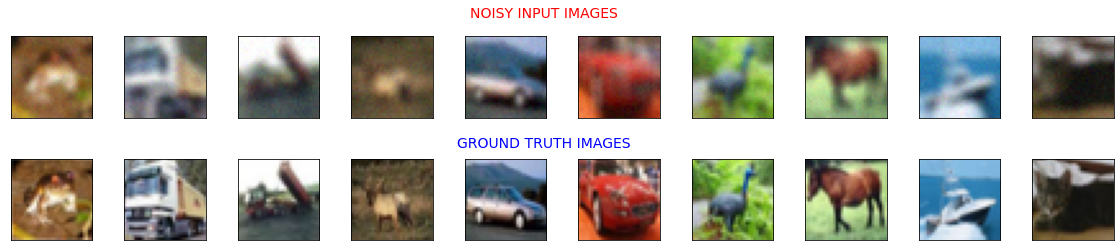

In [ ]:
train, test = getDataset()
x_train, y_train = train[0] , train[1]
x_test , y_test = test[0], test[1]
train, test = [], []
metrics_list = [PSNR,ssim, 'mae']
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
plot_imgs(x_train,y_train)
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# SEQUENTIAL ENCODER - DECODER

First of all let's implement a basic neural network based on convolutions and deconvolutions in order to set a baseline.
It is a sequential network composed by 3 main components:


1.   Encoder
2.   Dense layers to express the latent features
3.   Decoder



*   The encoder accepts in input the 32 x 32 RGB image and passes it to 3 subsequent convolutional block each of them composed by an increasing kernel (32, 64 and 128 in this case). Each convolutional block is composed by a convolution with stride 2, a batch normalization and a LeakyReLU as activation function. We end up this step with a 4 x 4 x 128 Tensor.

*  At this point it is useful to compress the information gained into a single latent vector and to do this flatten the previously obtained matrix and put a Dense layer with 512 neurons. The decoder will take this 512 Tensor and will apply another Dense, this time with dimension 2048 in order to restore the original number of features before the flatten operation. Finally the tensor is reshaped into a 4 x 4 x 128 such that deconvolutions layers can be added.

* The decoder is composed 3 deconvolutional blocks, which are identical w.r.t. the encoder but this time it is deployed the Transpose convolution instead of the standard convolution. After this step the output is a 32 x 32 x 32 Tensor so, in order to have an RGB image, a last Transpose convolution is needed. The last activation function is a sigmoid given that input and output images are mapped from 0 to 1

As last consideration I have implemented this architecture with the LeakyReLU activation function instead of ReLU, which allows a small gradient when the unit is not active, since it performs better on this model

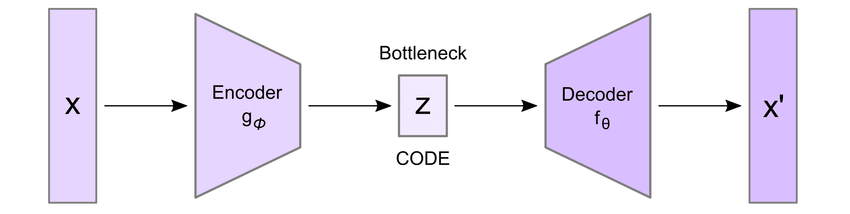

This model has: 2435459 parameters


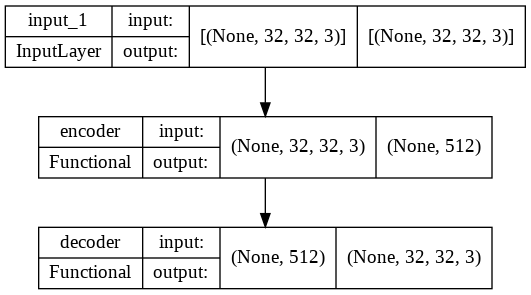

In [ ]:
def conv_block(input_layer, filter, chanDim=-1):
  # apply a CONV => RELU => BN operation
  x = Conv2D(filter, (3, 3), strides=2, padding="same")(input_layer)
  x = BatchNormalization(axis=chanDim)(x)
  x = LeakyReLU(alpha=0.2)(x)
  return x

def deconv_block(input_layer, filter, chanDim=-1):
  # apply a CONV_TRANSPOSE => RELU => BN operation
  x = Conv2DTranspose(filter, (3, 3), strides=2,padding="same")(input_layer)
  x = BatchNormalization(axis=chanDim)(x)
  x = LeakyReLU(alpha=0.2)(x)
  return x


def build_sequential_autoencoder(width, height, depth, filters=(32, 64,128), latentDim=512):

  inputShape = (height, width, depth)
  #ENCODER
  # define the input to the encoder
  inputs = Input(shape=inputShape)
  x = inputs
  # loop over the number of filters
  for f in filters:
    x = conv_block(x, f)
  #LATENT - ENCODER
  # flatten the network and to construct the latent vector
  volumeSize = K.int_shape(x)
  x = Flatten()(x)
  latent = Dense(latentDim)(x)
  # build the encoder model
  encoder = Model(inputs, latent, name="encoder")

  #DECODER
  # define the input to the decoder
  latentInputs = Input(shape=(latentDim,))
  #LATENT - DECODER
  # apply another Dense layer and reshape the image to permit convolutions
  x = Dense(np.prod(volumeSize[1:]))(latentInputs)
  x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
  # loop over our number of filters again, but this time in reverse order
  for f in filters[::-1]:
    x = deconv_block(x, f)
  # Finally we do a last deconvolution to recover the original depth of the image
  x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
  #Activation function of the model
  outputs = Activation("sigmoid")(x)

  # build the decoder model
  decoder = Model(latentInputs, outputs, name="decoder")

  # build the Autoencoder
  autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")

  return (encoder, decoder, autoencoder)

if TPU == True:
  with strategy.scope():
    (sequential_encoder, sequential_decoder, sequential_autoencoder) = build_sequential_autoencoder(32, 32, 3)
else:
  (sequential_encoder, sequential_decoder, sequential_autoencoder) = build_sequential_autoencoder(32, 32, 3)


sequential_autoencoder.compile(loss="mse", optimizer=opt, metrics=metrics_list)
print('This model has:',sequential_autoencoder.count_params(), 'parameters')
plot_model(sequential_autoencoder, to_file='sequential_autoencoder.png', show_shapes=True)

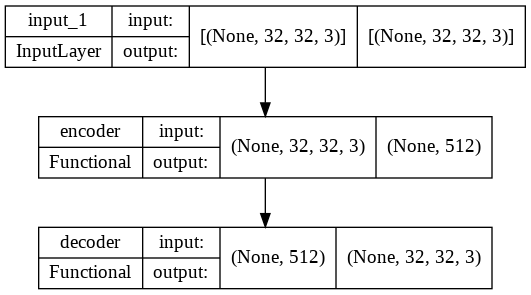

In [ ]:
plot_model(sequential_autoencoder, to_file='sequential_autoencoder.png', show_shapes=True)

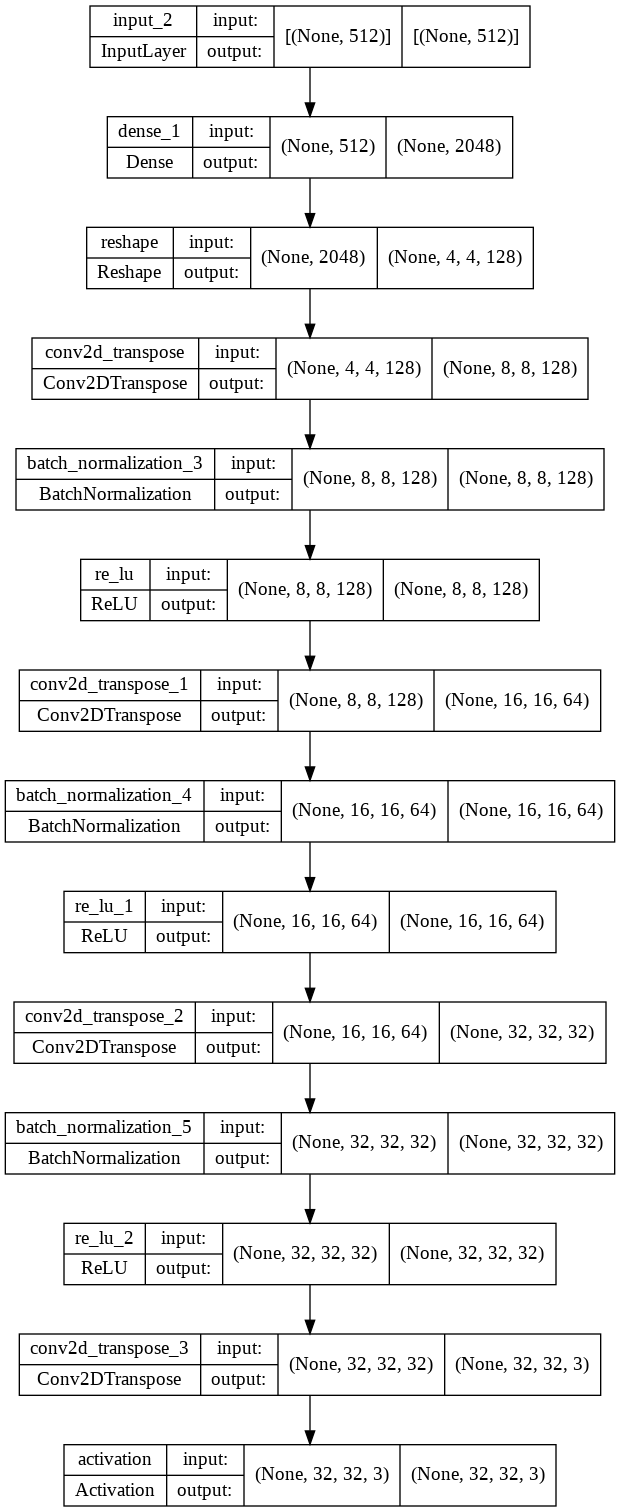

In [ ]:
plot_model(sequential_decoder, to_file='simple_decoder.png', show_shapes=True)

In [ ]:
hist_simple_autoencoder = sequential_autoencoder.fit(x_train, y_train, epochs=45, batch_size=64, validation_data=(x_test, y_test))
sequential_autoencoder.save_weights('simple_autoencoder.h5')

Epoch 1/45
782/782 [==============================] - 22s 14ms/step - loss: 0.0108 - PSNR: 20.5852 - ssim: 0.6714 - mae: 0.0746 - val_loss: 0.0072 - val_PSNR: 21.5799 - val_ssim: 0.7704 - val_mae: 0.0622
Epoch 2/45
782/782 [==============================] - 10s 13ms/step - loss: 0.0060 - PSNR: 22.4375 - ssim: 0.7870 - mae: 0.0569 - val_loss: 0.0054 - val_PSNR: 22.8728 - val_ssim: 0.8041 - val_mae: 0.0528
Epoch 3/45
782/782 [==============================] - 10s 13ms/step - loss: 0.0053 - PSNR: 23.2096 - ssim: 0.8083 - mae: 0.0534 - val_loss: 0.0057 - val_PSNR: 22.6074 - val_ssim: 0.8096 - val_mae: 0.0558
Epoch 4/45
782/782 [==============================] - 10s 13ms/step - loss: 0.0050 - PSNR: 23.4626 - ssim: 0.8195 - mae: 0.0514 - val_loss: 0.0049 - val_PSNR: 23.2668 - val_ssim: 0.8190 - val_mae: 0.0511
Epoch 5/45
782/782 [==============================] - 12s 15ms/step - loss: 0.0048 - PSNR: 23.6458 - ssim: 0.8258 - mae: 0.0504 - val_loss: 0.0046 - val_PSNR: 23.5256 - val_ssim: 0.828

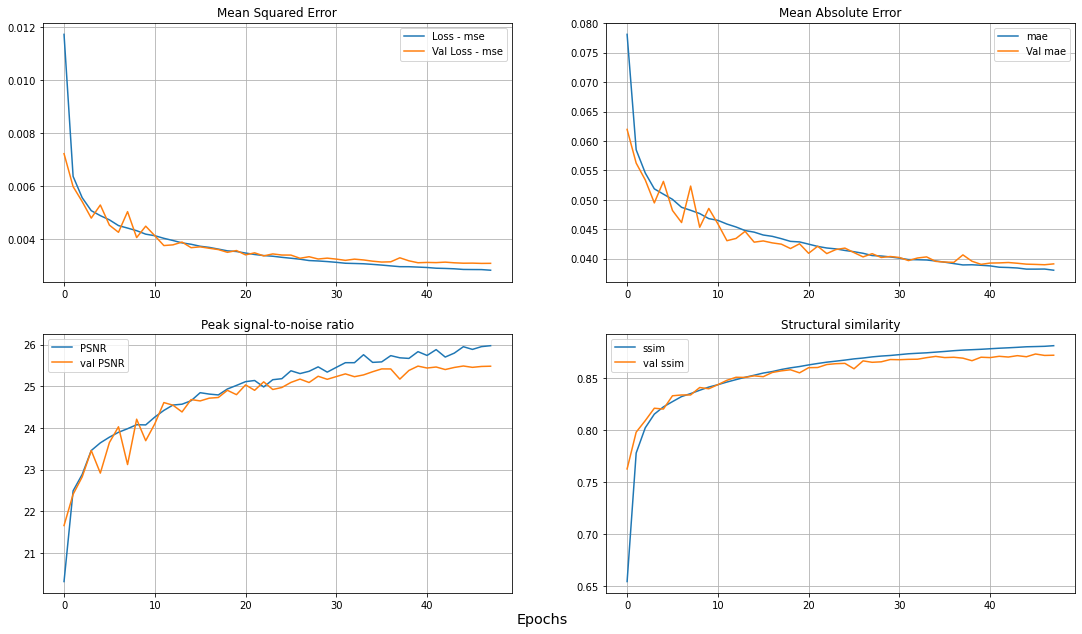

In [ ]:
plot_results(hist_simple_autoencoder)

As shown in the plots this model reaches a mean squared error of 0.0030 after 40 epochs (after which it starts overfitting) on the validation set, that, for such for a such simple network, is a good baseline.
Now let's plot some visual results in order to inspect visually the output of this network

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


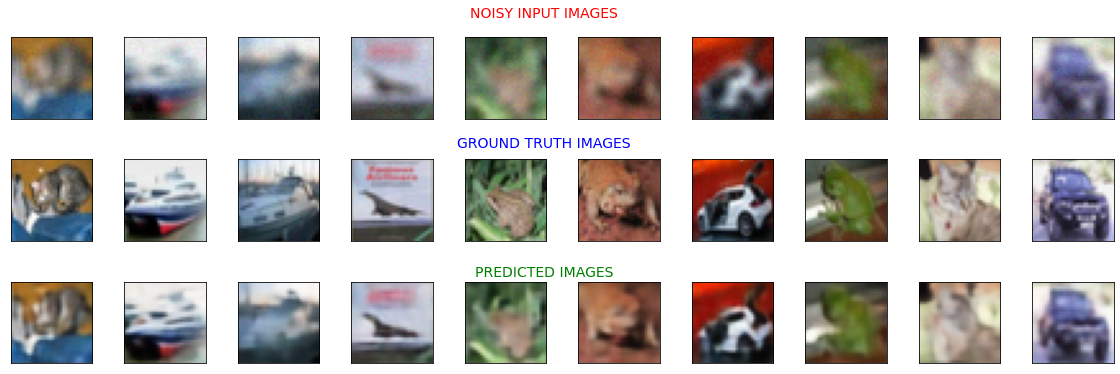

In [ ]:
y_pred_simple_auto = sequential_autoencoder.predict(x_test)
plot_imgs(x_test,y_test, y_pred_simple_auto)

# RESIDUAL ENCODER - DECODER

This time it is implemented a network which is very similar to the previously defined one, but this time with more convolutional/deconvolutional blocks and, most of all, skip connections from the Encoder to the Decoder have been added to back-propagate the gradients to bottom layers and pass image
details to the top layers. 
With such connection it is useful to keep the bottlenck made by the dense layers of the previous example given that with such architecture makes only the computation slower without an improvement in the performances.

It is composed first by a set of 5 convolutional block which are the same previously defined, each of them with stride 2 (except for the last convolution which is 1) and with kernels (32, 64, 128, 256, 256). Then there is a deconvolution phase which is composed by 4 deconvolutional blocks with the same kernels deployed before but in reverse order (256, 128, 64, 32), each of which is concatenated, at the end, with the output of the convolutional block with the same first two dimensions. Finally it is applied a last deconvolution in order to obtain an output with the same channels of an RGB image.

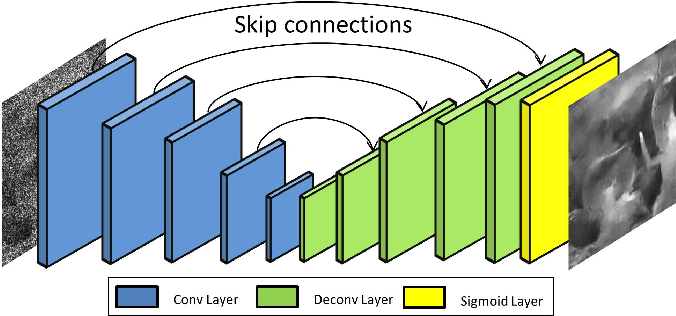

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x


def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x


def build_residual_autoencoder():
   #ENCODER
   inputs = Input(shape=(32, 32, 3), name='input')
   conv_block1 = conv_block(inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   #DECODER
   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)
   merge4 = Concatenate()([deconv_block4, inputs])

   final_deconv = Conv2DTranspose(filters=3, kernel_size=3, padding='same')(merge4)

   outputs = Activation("sigmoid")(final_deconv)

   return ks.models.Model(inputs, outputs, name='residual_autoencoder')

This model has: 2155220 parameters


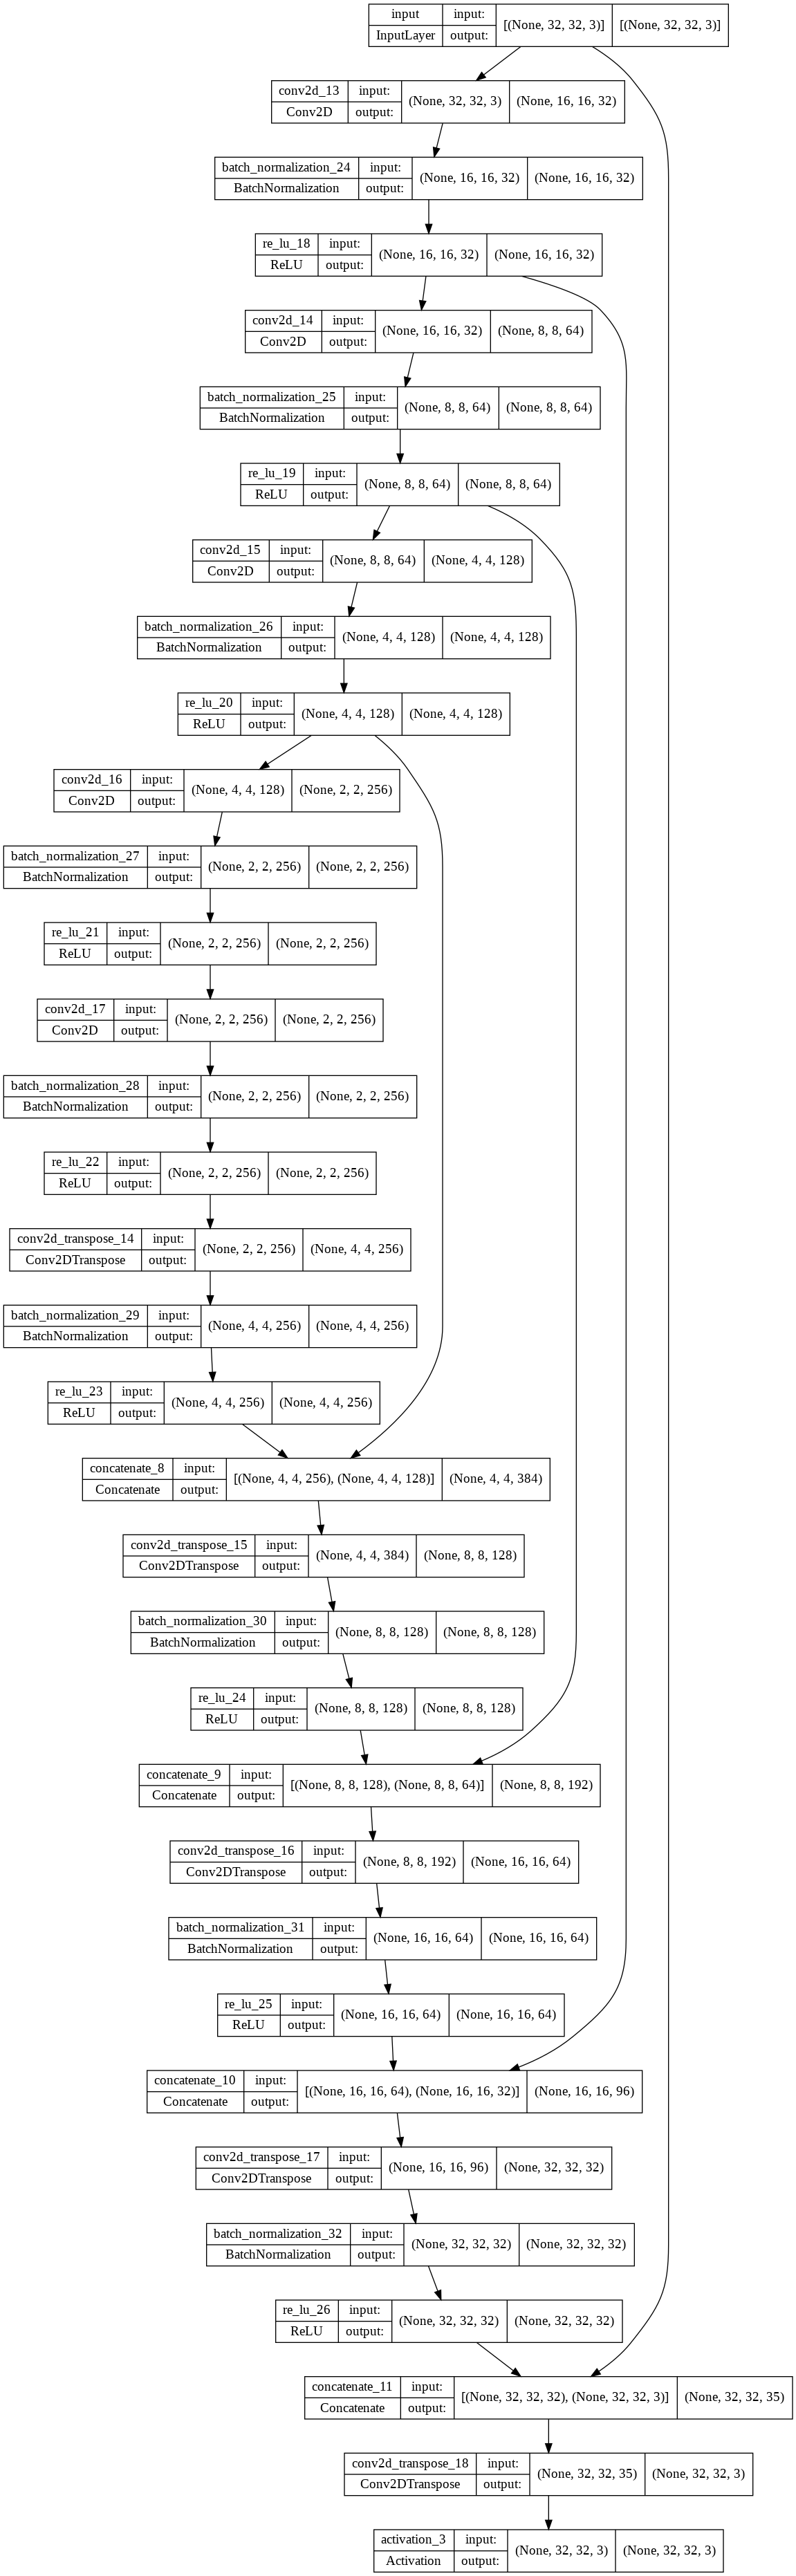

In [ ]:
if TPU == True:
  with strategy.scope():
    residual_autoencoder = build_residual_autoencoder()
else:
  residual_autoencoder = build_residual_autoencoder()
residual_autoencoder.compile(loss="mse", optimizer=opt, metrics=metrics_list)
print('This model has:',residual_autoencoder.count_params(), 'parameters')
plot_model(residual_autoencoder , to_file='residual_autoencoder.png', show_shapes=True)

In [ ]:
hist_residual_autoencoder = residual_autoencoder.fit(x_train, y_train, epochs=15, batch_size=50, validation_data=(x_test, y_test))
residual_autoencoder.save_weights('residual_autoencoder.h5')

Epoch 1/15
1000/1000 [==============================] - 16s 14ms/step - loss: 0.0056 - PSNR: 23.3248 - ssim: 0.8068 - mae: 0.0537 - val_loss: 0.0043 - val_PSNR: 24.1101 - val_ssim: 0.8293 - val_mae: 0.0472
Epoch 2/15
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0041 - PSNR: 24.4551 - ssim: 0.8441 - mae: 0.0463 - val_loss: 0.0041 - val_PSNR: 24.2343 - val_ssim: 0.8417 - val_mae: 0.0471
Epoch 3/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0035 - PSNR: 25.0249 - ssim: 0.8632 - mae: 0.0427 - val_loss: 0.0036 - val_PSNR: 24.7584 - val_ssim: 0.8656 - val_mae: 0.0438
Epoch 4/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0031 - PSNR: 25.5594 - ssim: 0.8722 - mae: 0.0404 - val_loss: 0.0032 - val_PSNR: 25.2632 - val_ssim: 0.8753 - val_mae: 0.0411
Epoch 5/15
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0030 - PSNR: 25.7460 - ssim: 0.8773 - mae: 0.0392 - val_loss: 0.0031 - val_PSNR: 25.4758 - val_s

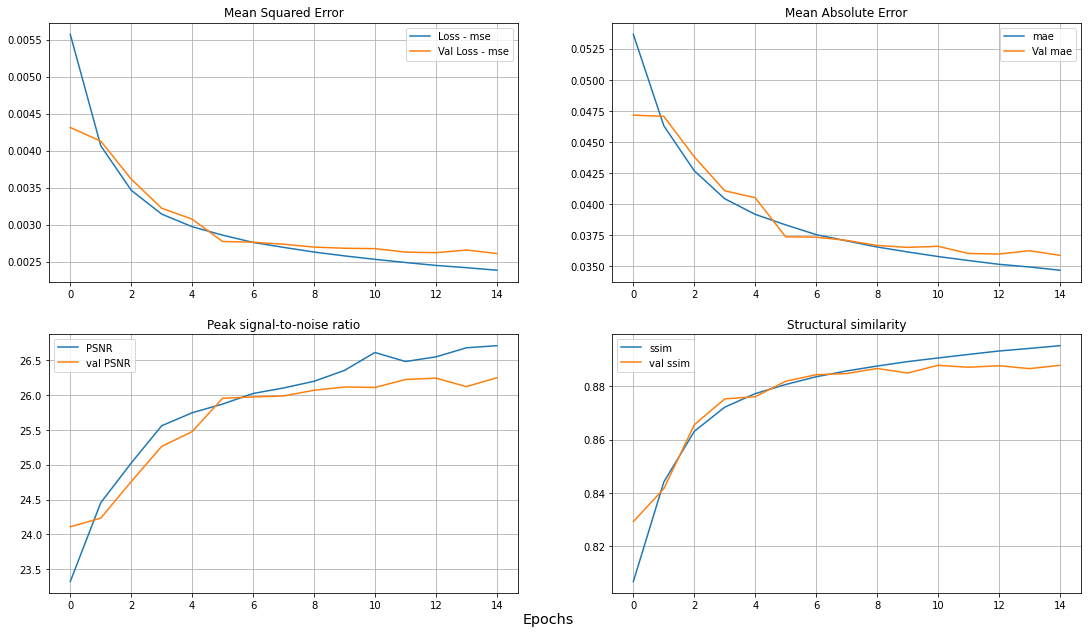

In [ ]:
plot_results(hist_residual_autoencoder)

As shown in the plots this architecture reaches a mean squared error of 0.0027 on the validation loss after 15 epochs (after which it starts overfitting) which is of course better than the previous architecture even with few less parameters pointing out the relevance of the skip connections to face the vanishing gradient problem 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


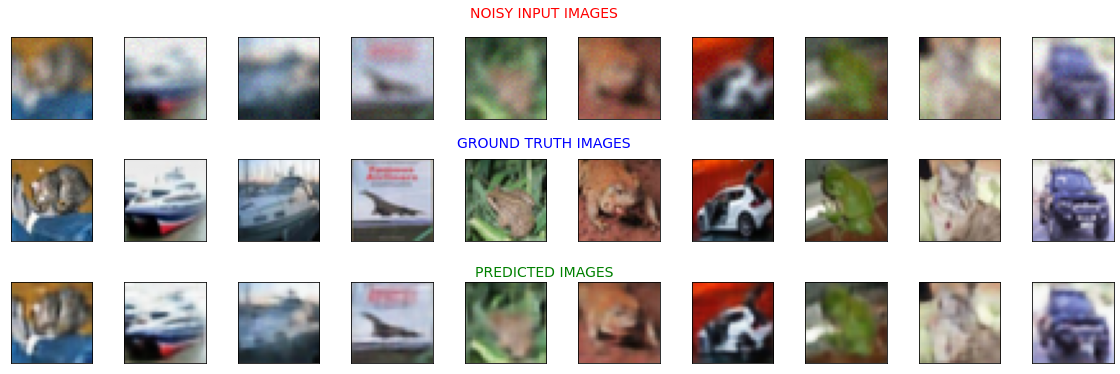

In [ ]:
y_pred_recurrent = residual_autoencoder.predict(x_test)
plot_imgs(x_test,y_test, y_pred_recurrent)

# DEEPER RESIDUAL ENCODER - DECODER: REDNET

Here I propose my version of the [RedNet](https://arxiv.org/pdf/1603.09056.pdf) architecture which is well known to be one of the best in the deblurring task:
RedNet is an architecture proposed by Mao et al. which consists in a set of convolutional and deconvolutional blocks.

Each block consists in a set of:
- Convolution/Deconvolution with stride 3 and 128 channels
- Batch normalization 
- ReLU activation function 

After 2 convolution blocks there is a skip connection to the respective deconvolution block, that is why in my implementation the convolution/deconvolution blocks are composed by 2 "standard" convolution block. 

Each convolution/deconvolution "standard" block is repeated for 15 times to implement the RedNet30 architecture. 

The last activation function is a Sigmoid (instead of the ReLU suggested by the paper) given that the output for each pixel must be comprise between 0 and 1.

Finally I have added a callback to reduce the learning rate when the model starts overfitting in order to obtain slightly better results

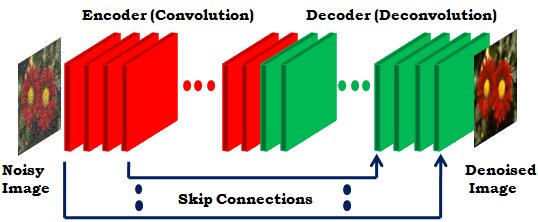

In [ ]:
def conv_block(x, filters = 128, kernel_size = (3, 3)):

  x = Conv2D(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  return x


def deconv_block(x, res,counter, filters = 128, kernel_size = (3,3)):
  x = Add()([x, res])
  x = ReLU()(x)
  x = Conv2DTranspose(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  if counter != 6:
    x = Conv2DTranspose(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
  else:
    x = Conv2DTranspose(3, kernel_size=kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
  return x

def middle_block(x, filters = 128, kernel_size = (3, 3)):
  x = Conv2D(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2DTranspose(filters, kernel_size=kernel_size, padding="same", use_bias=False)(x)
  x = BatchNormalization()(x)
  return x


def build_rednet(dimension = 30):
  

  residuals = []

  inputs = Input(shape=[32, 32, 3], name="InputImage")
  x = inputs
  
  for i in range(dimension//4):
    x = conv_block(x)
    residuals.append(x)

  x = middle_block(x)

  for i in range(dimension//4):
    x = deconv_block(x, residuals[-i], i)

  y = Add()([x, inputs])


  outputs = Activation("sigmoid")(y)

  return ks.models.Model(inputs, outputs, name='rednet')

In [ ]:
class LearningRateReducer(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    if epoch > 14:
      new_lr = old_lr * 0.8
      print("\nReducing Learning Rate from {} to {}".format(old_lr, new_lr))
      self.model.optimizer.lr.assign(new_lr)
    else:
      print("\nKeeping Learning Rate to {}".format(old_lr))

This model has: 4150540 parameters


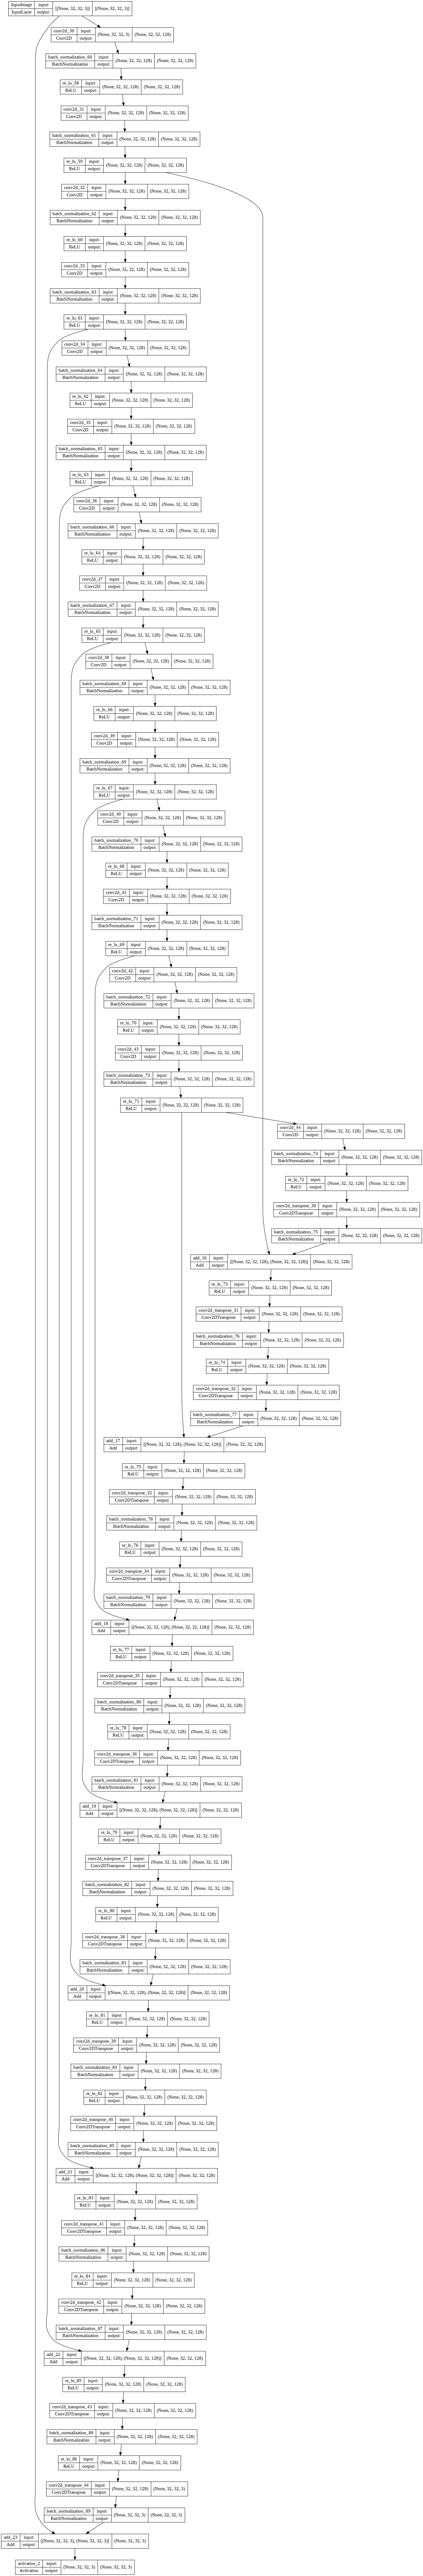

In [ ]:
if TPU == True:
  with strategy.scope():
    rednet = build_rednet()
else:
  rednet = build_rednet()
rednet.compile(loss="mse", optimizer=opt, metrics=metrics_list)
print('This model has:',rednet.count_params(), 'parameters')
plot_model(rednet, to_file='rednet.png', show_shapes=True)

In [ ]:
hist_rednet = rednet.fit(x_train, y_train, epochs=25, batch_size=64*2,
                      validation_data=(x_test, y_test), callbacks = [LearningRateReducer()])  
rednet.save_weights('rednet.h5')

Epoch 1/25
  6/391 [..............................] - ETA: 18s - loss: 0.0392 - PSNR: 15.3411 - ssim: 0.5193 - mae: 0.1516WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0049s vs `on_train_batch_end` time: 1.9663s). Check your callbacks.


391/391 [==============================] - ETA: 0s - loss: 0.0101 - PSNR: 20.8151 - ssim: 0.8175 - mae: 0.0798
Keeping Learning Rate to 0.0010000000474974513
391/391 [==============================] - 70s 117ms/step - loss: 0.0101 - PSNR: 20.8151 - ssim: 0.8175 - mae: 0.0798 - val_loss: 0.0163 - val_PSNR: 18.2872 - val_ssim: 0.6681 - val_mae: 0.1054
Epoch 2/25
390/391 [============================>.] - ETA: 0s - loss: 0.0041 - PSNR: 24.3768 - ssim: 0.8763 - mae: 0.0488
Keeping Learning Rate to 0.0010000000474974513
391/391 [==============================] - 21s 55ms/step - loss: 0.0041 - PSNR: 24.3770 - ssim: 0.8763 - mae: 0.0488 - val_loss: 0.0033 - val_PSNR: 25.0341 - val_ssim: 0.8777 - val_mae: 0.0429
Epoch 3/25
391/391 [==============================] - ETA: 0s - loss: 0.0033 - PSNR: 25.2998 - ssim: 0.8859 - mae: 0.0427
Keeping Learning Rate to 0.0010000000474974513
391/391 [==============================] - 22s 55ms/step - loss: 0.0033 - PSNR: 25.2998 - ssim: 0.8859 - mae: 0.0427 

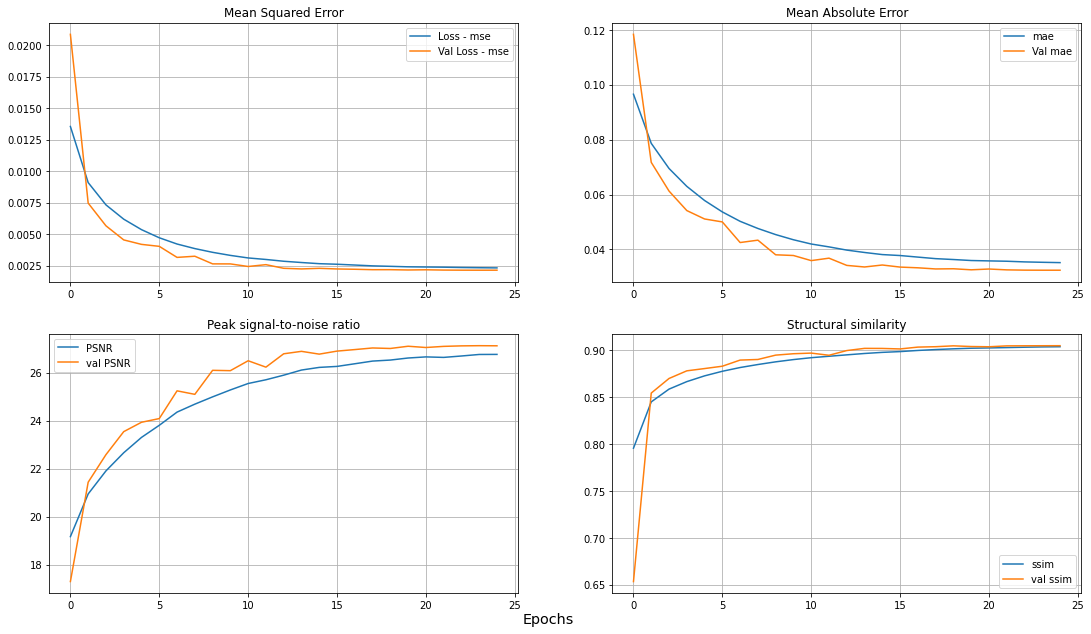

In [ ]:
plot_results(hist_rednet)

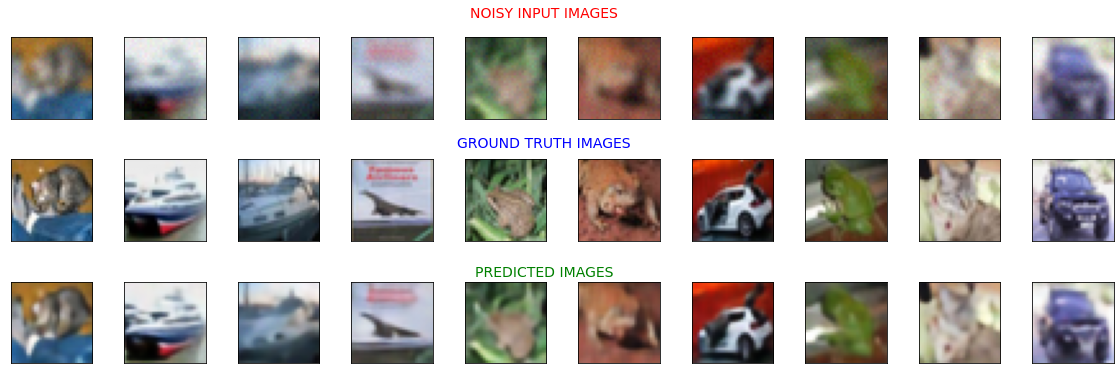

In [ ]:
y_pred_rednet = rednet.predict(x_test)
plot_imgs(x_test,y_test, y_pred_rednet)

As final remark as it is shown in the graphs and the plots this is for sure the architecture which performs the best, obtaining a mean squared error of 0.0020 after 25 epochs on the validation set.

Of course this is the most complex model between the three in terms of structure and number of parameters.